## We first construct store-level features

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Construct store-level features
df_demo= pd.read_csv('state_demographics.csv')

In [3]:
state_mapping = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [4]:
df_demo['STATE'] = df_demo['State'].map(state_mapping)
df_demo['MenRatio'] = df_demo['Men'] / df_demo['TotalPop']
df_demo['WomenRatio'] = df_demo['Women'] / df_demo['TotalPop']

In [5]:
df_selected=df_demo[['STATE','MenRatio','WomenRatio','White','Black','Native','Asian','Pacific','Income','Poverty','Professional','Service','Office','Construction','Production','Unemployment']]
result_df = df_selected.groupby('STATE').mean().reset_index()


In [12]:
df_final =pd.read_csv('df_final_sku_store_quarter_noextinfo.csv')

In [13]:
df_final.head()

,Unnamed: 0,STORE,COUNT_ITEMS,SKU,quarter,totalunitssold,averageoriginalprice,averagesellingprice,purchase_count,return_count,...,VENDOR,BRAND,CLASSID,CITY,STATE,ZIP,COST,RETAIL,PROF_MARG,DISCOUNTED
0,0,102,96312,387,Q4,2,79.0,65.965,2,0,...,5016699,TIMBERLA,913,TAMPA,FL,33607,38.0,79.0,0.481013,True
1,1,102,96312,450,Q3,3,6.0,3.360,3,0,...,6713105,INTERNAT,203,TAMPA,FL,33607,2.0,3.0,0.666667,True
2,2,102,96312,788,Q3,2,18.0,18.000,2,0,...,9520439,BALI/HEN,873,TAMPA,FL,33607,8.0,18.0,0.444444,False
3,3,102,96312,1634,Q2,2,60.0,60.000,2,0,...,5010255,ENZO ANG,214,TAMPA,FL,33607,28.5,60.0,0.475000,False
4,4,102,96312,1634,Q3,2,60.0,33.000,2,0,...,5010255,ENZO ANG,214,TAMPA,FL,33607,28.5,60.0,0.475000,True


In [14]:
#merge with the original data 
merged_df = pd.merge(df_final ,result_df, left_on='STATE', right_on='STATE', how='inner')

## Create and Transform Target: log revenue

In [15]:
merged_df['total_count'] = merged_df['purchase_count'] + merged_df['return_count']
merged_df['revenue'] = merged_df['averagesellingprice'] * merged_df['totalunitssold']

(0.0, 1000.0)

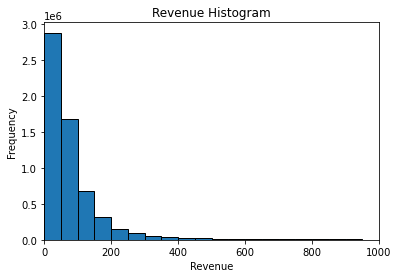

In [18]:
# Create a histogram and set the x-axis scale
plt.hist(merged_df['revenue'], bins=20, range=(0, 1000), edgecolor='black')  # Adjust the number of bins as needed
plt.title('Revenue Histogram')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.xlim(0, 1000)

In [41]:
merged_df['log_rev'] = np.log(merged_df['revenue'] + 0.001)

In [42]:
merged_df.columns

Index(['Unnamed: 0', 'STORE', 'COUNT_ITEMS', 'SKU', 'quarter',
       'totalunitssold', 'averageoriginalprice', 'averagesellingprice',
       'purchase_count', 'return_count', 'purchase_prob', 'DEPT', 'PACKSIZE',
       'VENDOR', 'BRAND', 'CLASSID', 'CITY', 'STATE', 'ZIP', 'COST', 'RETAIL',
       'PROF_MARG', 'DISCOUNTED', 'MenRatio', 'WomenRatio', 'White', 'Black',
       'Native', 'Asian', 'Pacific', 'Income', 'Poverty', 'Professional',
       'Service', 'Office', 'Construction', 'Production', 'Unemployment',
       'total_count', 'revenue', 'log_rev'],
      dtype='object')

## Numerical Feature Selection 

In [43]:
sampled_df = merged_df.sample(n=100000, random_state=42)

In [45]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

# Assuming 'df_train_sampled' is your sampled DataFrame
X = sampled_df.drop(['Unnamed: 0', 'STATE', 'BRAND', 'CLASSID', 'revenue', 'total_count',
                    'purchase_count', 'return_count', 'totalunitssold', 'log_rev',  'CITY', 'STATE', 'ZIP',
                     'quarter'
                    ], axis=1)
y = sampled_df['log_rev']

# Define Linear Regression as the model
lr = LinearRegression()

# Perform stepwise feature selection with limited number of features and parallelization
sfs = SFS(lr, 
          k_features=(10, 20),  # Change to a tuple (min_features, max_features) to test
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=5,  # Reduced number of folds
          n_jobs=-1)  # Use all available CPU cores

# Fit the model
sfs = sfs.fit(X, y)

# Get the selected feature indices
selected_features = X.columns[list(sfs.k_feature_idx_)]

# Print the selected features
print(selected_features)

Index(['COUNT_ITEMS', 'averageoriginalprice', 'averagesellingprice',
       'purchase_prob', 'DEPT', 'PACKSIZE', 'VENDOR', 'COST', 'RETAIL',
       'DISCOUNTED', 'White', 'Black', 'Asian', 'Poverty', 'Professional',
       'Office', 'Construction', 'Unemployment'],
      dtype='object')


In [46]:
merged_df.columns

Index(['Unnamed: 0', 'STORE', 'COUNT_ITEMS', 'SKU', 'quarter',
       'totalunitssold', 'averageoriginalprice', 'averagesellingprice',
       'purchase_count', 'return_count', 'purchase_prob', 'DEPT', 'PACKSIZE',
       'VENDOR', 'BRAND', 'CLASSID', 'CITY', 'STATE', 'ZIP', 'COST', 'RETAIL',
       'PROF_MARG', 'DISCOUNTED', 'MenRatio', 'WomenRatio', 'White', 'Black',
       'Native', 'Asian', 'Pacific', 'Income', 'Poverty', 'Professional',
       'Service', 'Office', 'Construction', 'Production', 'Unemployment',
       'total_count', 'revenue', 'log_rev'],
      dtype='object')

## Dropping Unimportant Features

In [49]:
df_final = merged_df.drop(columns = ['Unnamed: 0', 'WomenRatio', 'Black',
       'Native', 'Pacific', 'Service', 'Office', 'Production',  'CITY', 'ZIP'])

## Dummy Variable for Brand and Color 

In [50]:
categorical_variables = [
    "STATE",
    "STORE",
    "CLASSID", 
    "quarter", 
    "DEPT"
]

In [51]:
df_dummies = pd.get_dummies(df_final, columns=categorical_variables, drop_first=True)

In [52]:
df_dummies.head()

,COUNT_ITEMS,SKU,totalunitssold,averageoriginalprice,averagesellingprice,purchase_count,return_count,purchase_prob,PACKSIZE,VENDOR,BRAND,COST,RETAIL,PROF_MARG,DISCOUNTED,MenRatio,White,Asian,Income,Poverty,Professional,Construction,Unemployment,total_count,revenue,log_rev,STATE_AR,STATE_AZ,STATE_CA,STATE_CO,STATE_FL,STATE_GA,STATE_IA,STATE_ID,STATE_IL,STATE_IN,STATE_KS,STATE_KY,STATE_LA,STATE_MO,STATE_MS,STATE_MT,STATE_NC,STATE_NE,STATE_NM,STATE_NV,STATE_OH,STATE_OK,STATE_SC,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_WY,STORE_103,STORE_107,STORE_202,STORE_203,STORE_204,STORE_209,STORE_302,STORE_303,STORE_304,STORE_307,STORE_309,STORE_402,STORE_403,STORE_404,STORE_407,STORE_409,STORE_502,STORE_503,STORE_504,STORE_507,STORE_509,STORE_603,STORE_604,STORE_609,STORE_703,STORE_704,STORE_707,STORE_709,STORE_802,STORE_807,STORE_809,STORE_902,STORE_903,STORE_907,STORE_909,STORE_1002,STORE_1003,STORE_1004,STORE_1007,STORE_1009,STORE_1102,STORE_1103,STORE_1104,STORE_1107,STORE_1109,STORE_1202,STORE_1203,STORE_1204,STORE_1207,STORE_1302,STORE_1304,STORE_1307,STORE_1402,STORE_1403,STORE_1404,STORE_1407,STORE_1502,STORE_1509,STORE_1602,STORE_1607,STORE_1609,STORE_1702,STORE_1703,STORE_1707,STORE_1709,STORE_1807,STORE_1904,STORE_1909,STORE_2004,STORE_2007,STORE_2009,STORE_2102,STORE_2103,STORE_2104,STORE_2109,STORE_2202,STORE_2203,STORE_2204,STORE_2207,STORE_2209,STORE_2303,STORE_2304,STORE_2307,STORE_2309,STORE_2402,STORE_2404,STORE_2407,STORE_2409,STORE_2502,STORE_2503,STORE_2504,STORE_2509,STORE_2602,STORE_2603,STORE_2604,STORE_2607,STORE_2609,STORE_2702,STORE_2704,STORE_2707,STORE_2804,STORE_2807,STORE_2809,STORE_2904,STORE_2907,STORE_2909,STORE_3002,STORE_3003,STORE_3004,STORE_3007,STORE_3009,STORE_3102,STORE_3103,STORE_3107,STORE_3109,STORE_3202,STORE_3204,STORE_3207,STORE_3209,STORE_3302,STORE_3303,STORE_3304,STORE_3307,STORE_3309,STORE_3402,STORE_3403,STORE_3407,STORE_3409,STORE_3502,STORE_3503,STORE_3504,STORE_3507,STORE_3509,STORE_3602,STORE_3603,STORE_3604,STORE_3607,STORE_3609,STORE_3702,STORE_3704,STORE_3707,STORE_3709,STORE_3802,STORE_3804,STORE_3807,STORE_3809,STORE_3902,STORE_3909,STORE_4003,STORE_4004,STORE_4007,STORE_4102,STORE_4103,STORE_4104,STORE_4107,STORE_4109,STORE_4202,STORE_4203,STORE_4204,STORE_4207,STORE_4209,STORE_4302,STORE_4303,STORE_4307,STORE_4309,STORE_4402,STORE_4403,STORE_4404,STORE_4407,STORE_4409,STORE_4502,STORE_4503,STORE_4504,STORE_4507,STORE_4603,STORE_4604,STORE_4607,STORE_4702,STORE_4703,STORE_4704,STORE_4707,STORE_4802,STORE_4803,STORE_4804,STORE_4807,STORE_4902,STORE_4903,STORE_4904,STORE_4907,STORE_5002,STORE_5004,STORE_5102,STORE_5103,STORE_5104,STORE_5202,STORE_5203,STORE_5204,STORE_5302,STORE_5303,STORE_5304,STORE_5402,STORE_5403,STORE_5404,STORE_5502,STORE_5503,STORE_5504,STORE_5602,STORE_5603,STORE_5604,STORE_5704,STORE_5802,STORE_5803,STORE_5804,STORE_5903,STORE_5904,STORE_6002,STORE_6004,STORE_6009,STORE_6102,STORE_6104,STORE_6109,STORE_6202,STORE_6203,STORE_6204,STORE_6209,STORE_6302,STORE_6304,STORE_6402,STORE_6403,STORE_6404,STORE_6503,STORE_6604,STORE_6703,STORE_6704,STORE_6804,STORE_6902,STORE_6903,STORE_6904,STORE_7002,STORE_7003,STORE_7004,STORE_7007,STORE_7102,STORE_7103,STORE_7104,STORE_7107,STORE_7202,STORE_7204,STORE_7302,STORE_7303,STORE_7304,STORE_7307,STORE_7402,STORE_7403,STORE_7404,STORE_7407,STORE_7502,STORE_7503,STORE_7507,STORE_7602,STORE_7603,STORE_7604,STORE_7702,STORE_7703,STORE_7704,STORE_7707,STORE_7804,STORE_7807,STORE_7902,STORE_7904,STORE_7907,STORE_8002,STORE_8004,STORE_8007,STORE_8102,STORE_8109,STORE_8202,STORE_8204,STORE_8209,STORE_8302,STORE_8309,STORE_8402,STORE_8403,STORE_8404,STORE_8407,STORE_8409,STORE_8503,STORE_8504,STORE_8507,STORE_8602,STORE_8603,STORE_8604,STORE_8607,STORE_8609,STORE_8702,STORE_8703,STORE_8707,STORE_8709,STORE_8802,STORE_8803,STORE_8902,STORE_9002,STORE_9103,STORE_9104,STORE_9202,STORE_9204,STORE_9209,STORE_9302,STORE_9303,STORE_9304,STORE_9309,STORE_9402,STORE_9404,STORE_9409,STORE_9503,STORE_9504,STORE_9603,STORE_9604,STORE_9609,S